In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

In [157]:
%%capture

import sys

# to install with pip
! pip install wbgapi
! pip install pandas
! pip install matplotlib
! pip install scipy
! pip install pytrends

import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from pytrends.request import TrendReq
import pytrends

## World Bank Data

### Download WDI data

From the WDI we need three indicators:

    Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, “NY.GDP.PCAP.PP.KD”)

    The amount of Internet users (per 100 people, “IT.NET.USER.ZS”)

    The total population (described as as “Population, Total”, “SP.POP.TOTL”)

In the following code chunk, download all data (including extras) for all countries in year 2014.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use 'skipAggs=True'.

In [184]:
def get_world_bank_data(year, internet_User):
  WDIdf = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'SP.POP.TOTL', 'IT.NET.USER.ZS'],
             labels = True,time=year, skipAggs=True)
  #only keep complete cases (drop any row that has NAs)
  WDIdf=WDIdf.dropna().reset_index(drop=True )
  WDIdf['IT.Net.USER']=WDIdf['IT.NET.USER.ZS']*WDIdf['SP.POP.TOTL']/100
  #filter for at least 5 Million internet users
  WDIdf=WDIdf[WDIdf['IT.Net.USER']>=internet_User].reset_index(drop=True)
  return WDIdf

## The Future Orientation Index in Google Trends

### Download data from Google Trends

You can download the data from Google Trends following these steps:

    Log out from your google account or set its language to English
    
    Go to trends.google.com and search for 2013
    
    Add 2015 as a search term
    
    Select custom time rage: full year: 2014
    
    Set the region to “Worldwide”. You can also try with this link: https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015
    
    Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”
    
    On the top right menu click the download button to get a geoMap.csv file

Load the .csv file, drop NAs and bring it in the right data format.

If you have problems getting the file from the web interface, we also included it in the github repository.

### Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [208]:
def get_trends_data(year):
  all_keywords = [str(year-1), str(year+1)]
  pytrends = TrendReq(hl='en-US', tz=360)
  pytrends.build_payload(all_keywords, cat=0, timeframe=f'{year}-01-01 {year}-12-30', geo='', gprop='')
  gMap=pytrends.interest_by_region(resolution='COUNTRY', inc_low_vol=True, inc_geo_code=False)
  gMap=gMap.dropna(axis='rows').reset_index()
  gMap=gMap.rename(columns={'geoName':'Country'})
  gMap['FOI']=gMap[str(year+1)]/gMap[str(year-1)]
  return gMap

### Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country.

In [210]:
def get_total_data(year, internet_User):
  WDIdf=get_world_bank_data(year,internet_User)
  gMap=get_trends_data(year)
  Totdf=WDIdf.merge(gMap, how='inner', on='Country')
  Totdf.drop(columns=['IT.Net.USER'], inplace=True)
  return Totdf

## Testing the correlation between GDP and FOI

### Visualize FOI vs GDP

Now that you have the FOI index and GPD per capita, PPP value for each country, you can make a scatter plot of FOI vs GDP.

In [229]:
def plot_scatter(year,internet_User,ax,color ):
  Totdf=get_total_data(year, internet_User)
  corr_coeff , p_value=stats.pearsonr( x=Totdf['FOI'] , y=Totdf['NY.GDP.PCAP.PP.KD']) 
  result = stats.linregress( x=Totdf['FOI'] , y=Totdf['NY.GDP.PCAP.PP.KD'])
  sns.regplot(data=Totdf, x='FOI' , y='NY.GDP.PCAP.PP.KD', ax=ax, color=color,line_kws={ 'label':f'Fitted y={np.round(result.slope,1)}x{np.round(result.intercept,1)}'},label='Empirical' )
  ax.set_ylabel('GDP per capita')
  ax.set_xlabel('FOI')
  ax.set_title(f'GDP vs. FOI, Internet_user={internet_User/1e6} Millions Year={year}')
  ax.legend(loc='upper left', borderpad=.2)
  ax.text(0.55, 0.15,f'Correlation Coefficient={np.round(corr_coeff,2)}, P-value={np.round(p_value,3)}', ha='center', va='center', transform=ax.transAxes, fontsize=9)

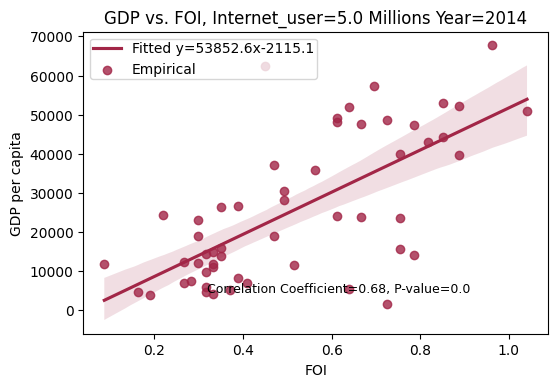

In [230]:
fig , ax= plt.subplots(nrows=1 , ncols=1 , figsize=(6 , 4) , dpi=100)
plot_scatter(2014, 5e6, ax,'#A22647')

### Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI

### Measure correlation after shuffling

What happens if we shuffle the data (e.g. shuffle the FOIs) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

In [232]:
def shuffle(ax):
  Totdf=get_total_data(2014, 5e6)
  Totdf['Shuff_FOI'] = np.random.permutation(Totdf['FOI'].values)
  result = stats.linregress( x=Totdf['Shuff_FOI'] , y=Totdf['NY.GDP.PCAP.PP.KD'])
  corr_coeff , p_value=stats.pearsonr( x=Totdf['Shuff_FOI'] , y=Totdf['NY.GDP.PCAP.PP.KD']) 
  sns.regplot(data=Totdf, x='Shuff_FOI' , y='NY.GDP.PCAP.PP.KD', ax=ax, color='#1689D8',line_kws={ 'label':f'Fitted y={np.round(result.slope,1)}x{np.round(result.intercept,1)}'},label='Empirical' )
  ax.set_ylabel('GDP per capita')
  ax.set_xlabel('Shuffeled FOI')
  ax.set_title('GDP vs. Shuffeled FOI,')
  ax.legend(loc='upper left', borderpad=.2)
  ax.text(0.4, 0.6,f'Corr_Coeff={np.round(corr_coeff,2)}, P-value={np.round(p_value,2)}', ha='center', va='center', transform=ax.transAxes, fontsize=9)

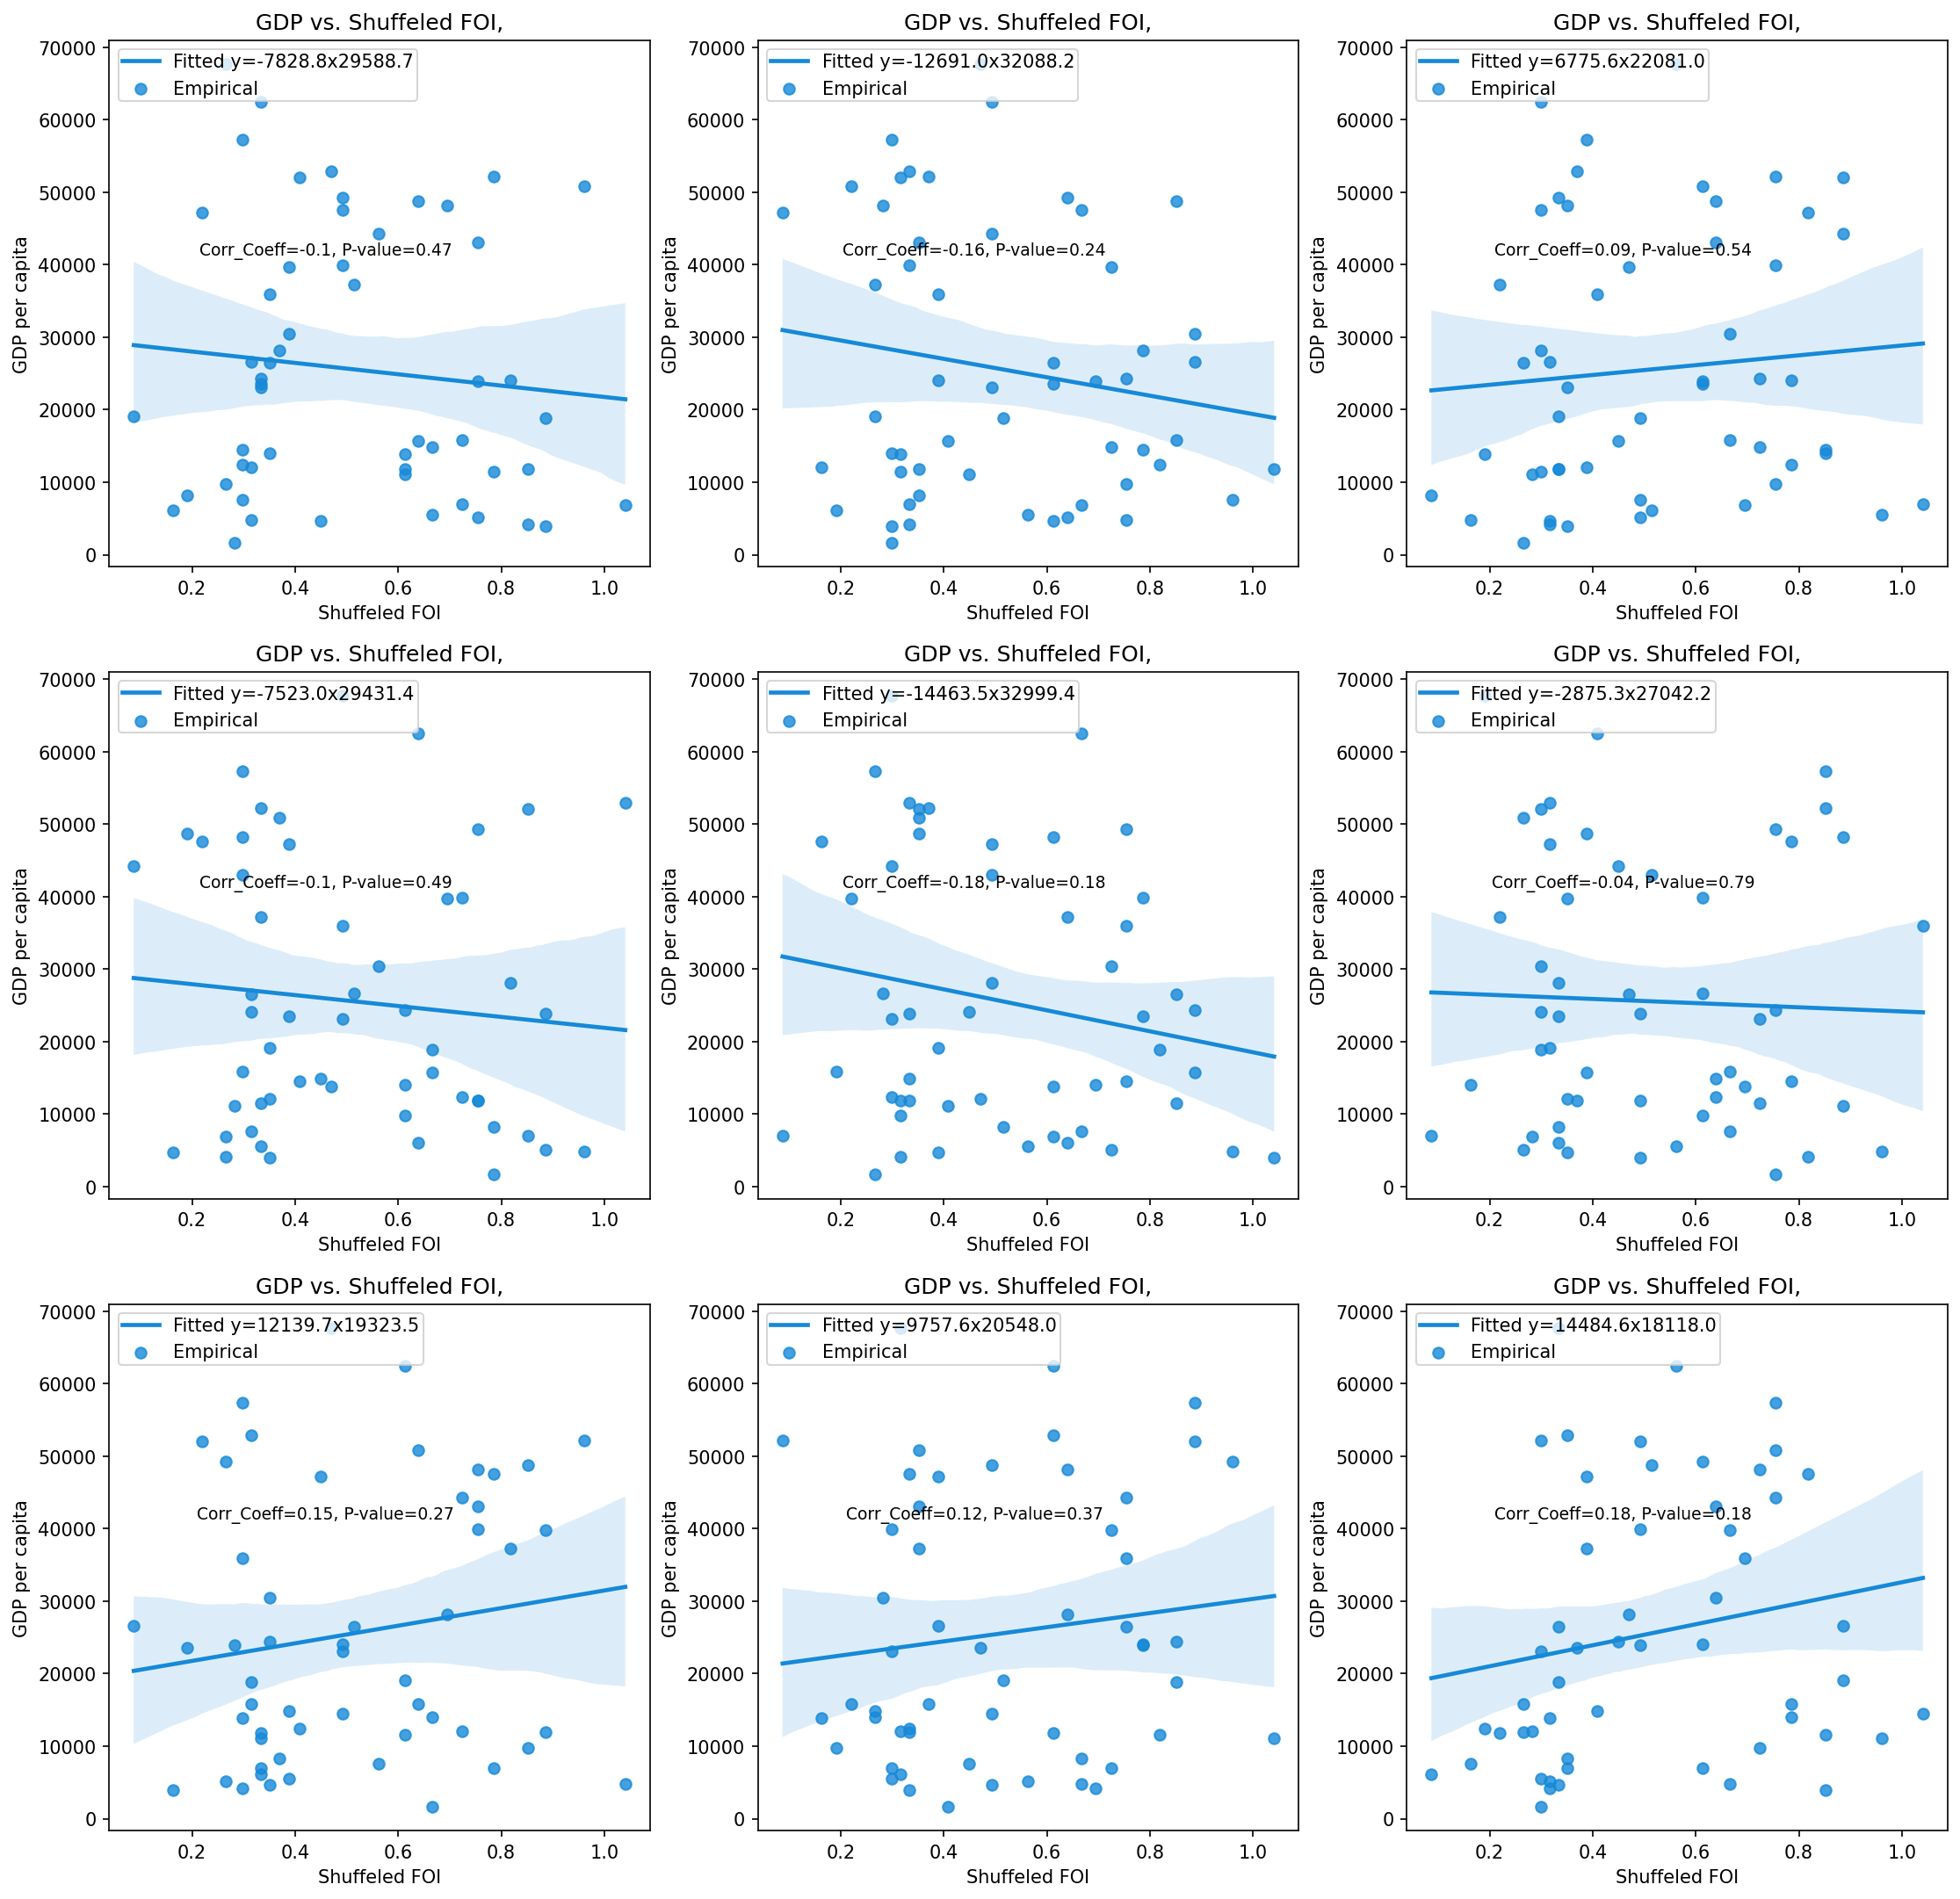

In [233]:
fig , ax= plt.subplots(nrows=3 , ncols=3 , figsize=(18 , 18) , dpi=150)
ax=ax.flat
for i in range(len(ax)):
  shuffle(ax[i])

## If you want to do more

### Check robustness

    What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
    
    How do results change if you use a different threshod instead of 5 Million Internet users?
    
### Test other hypotheses
    
    Is future orientation generating wealth? Or is wealth enabling to look more to the future?
    
    Is the FOI really measuring orientation to the future? Could it be something else?

Text(0.5, 0.98, 'GDP VS FOI Year=2014')

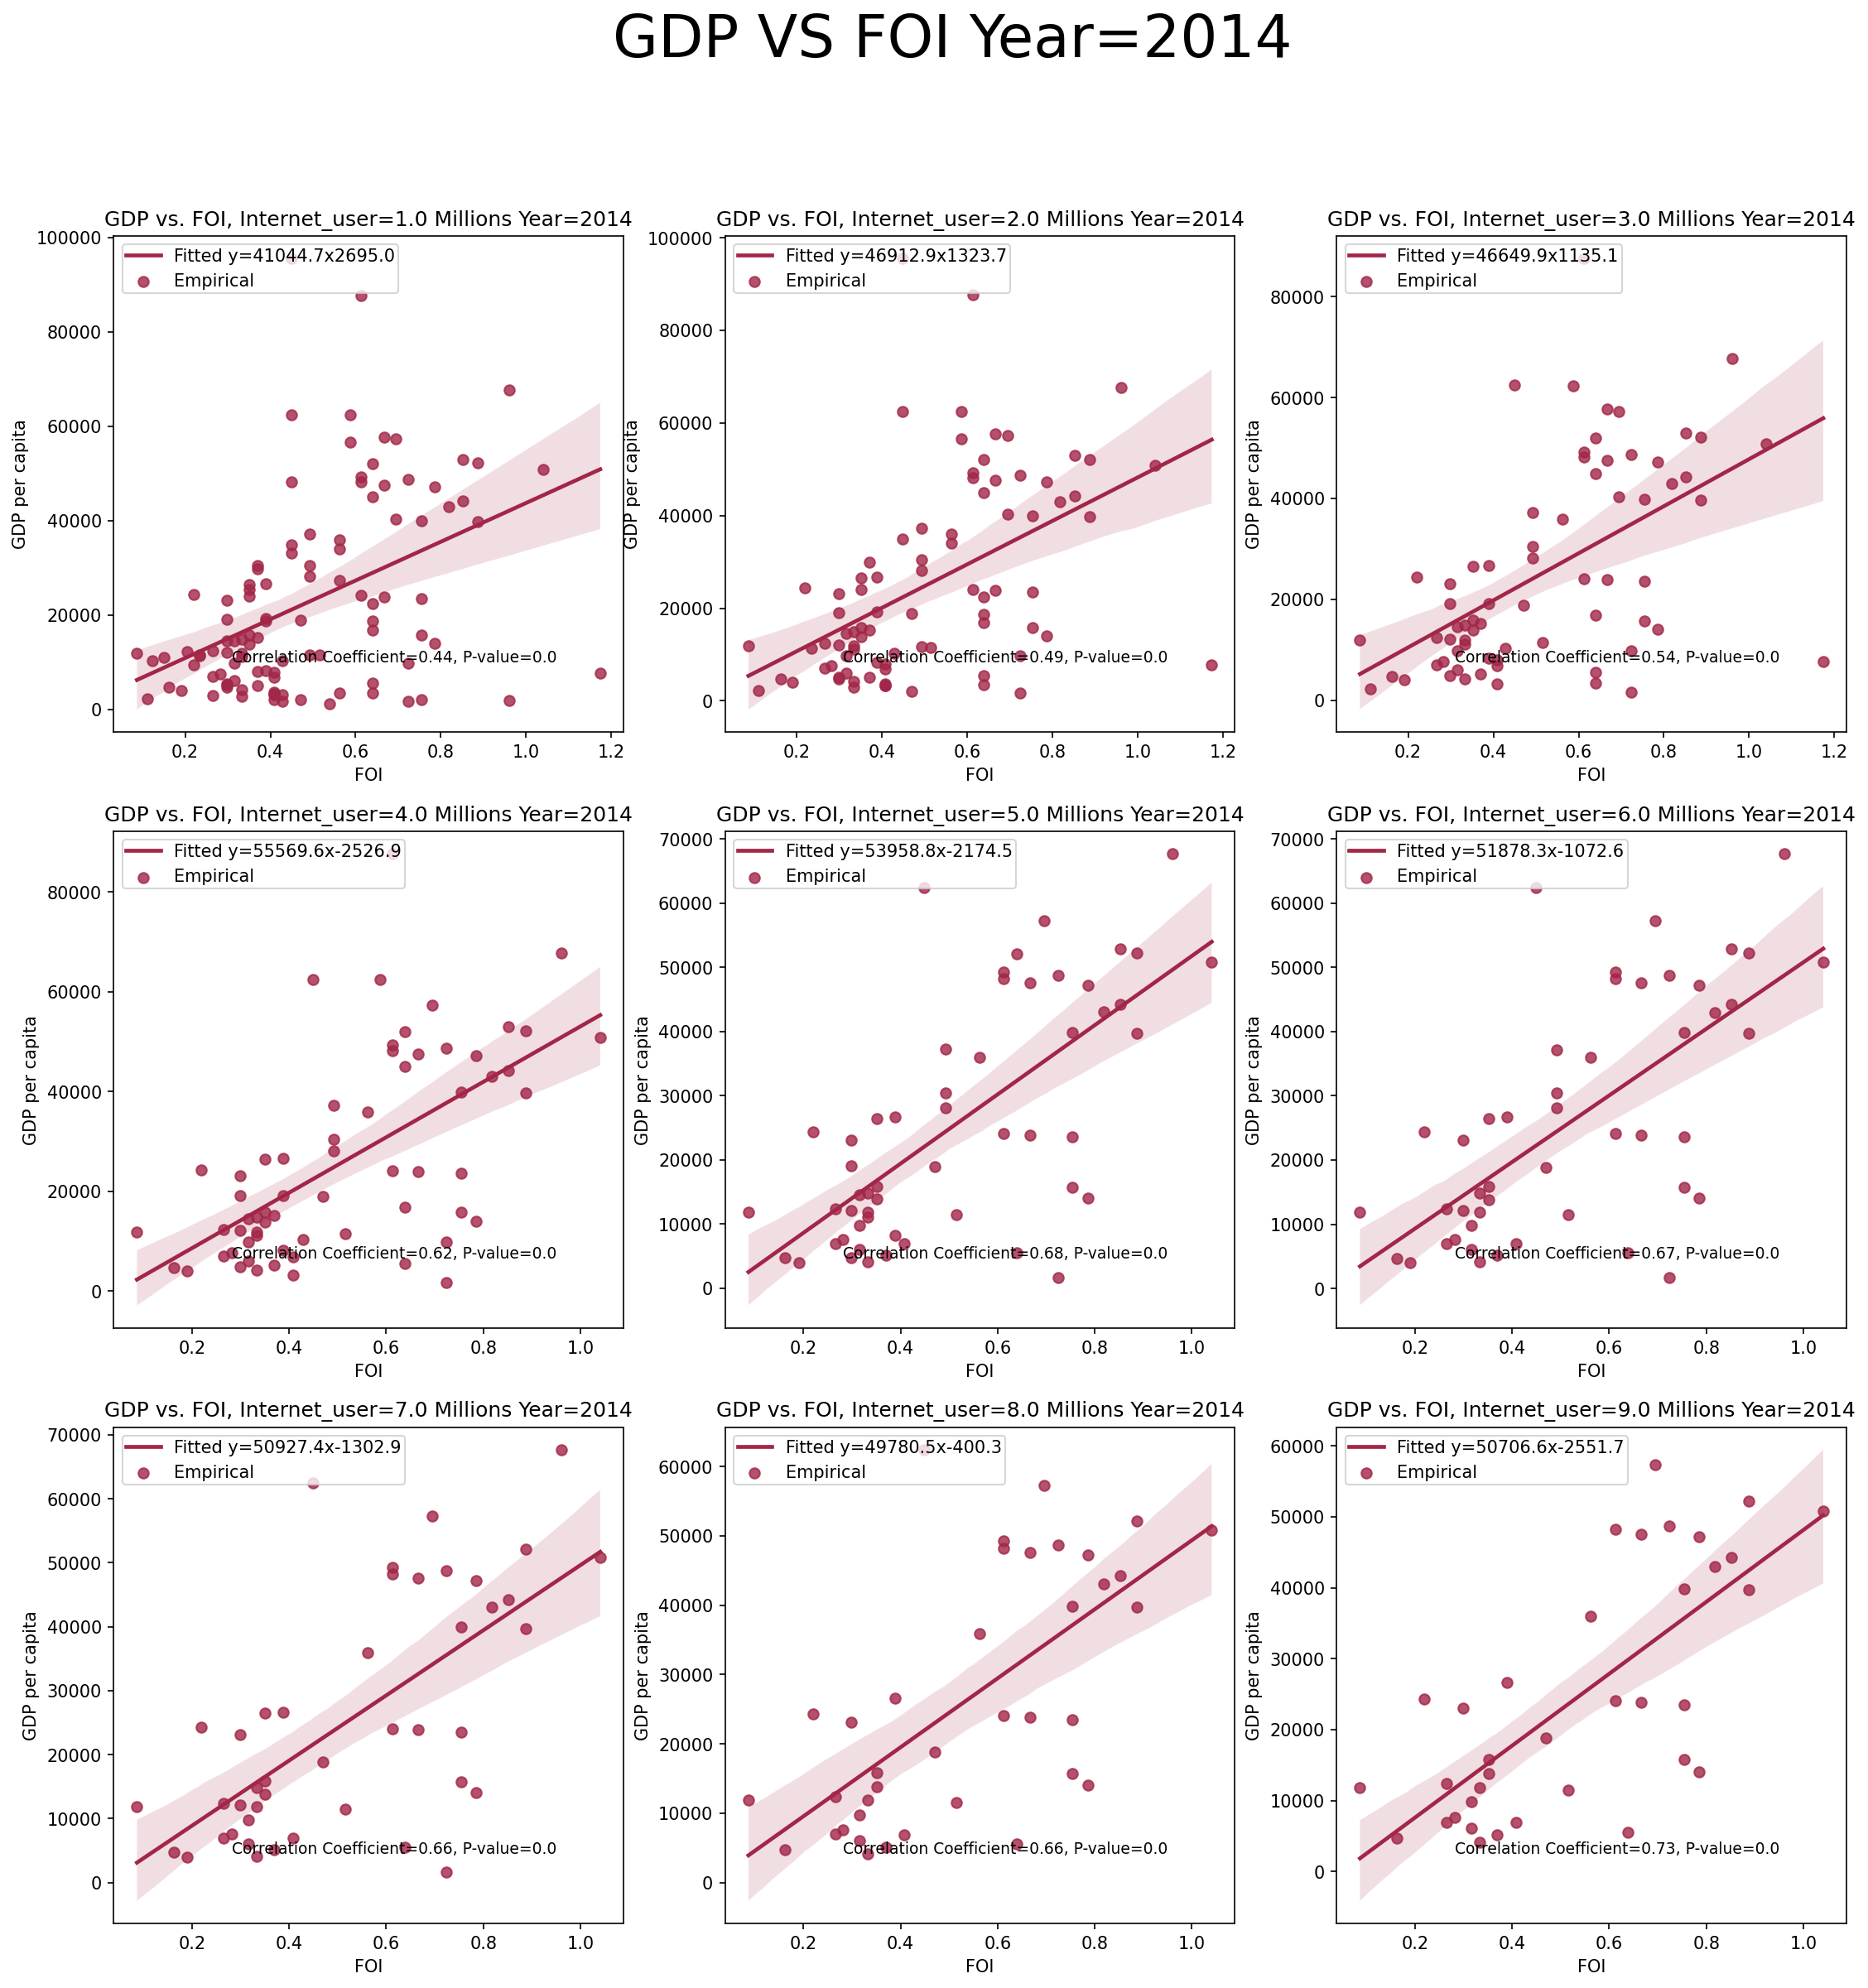

In [227]:
import seaborn as sns
fig , ax= plt.subplots(nrows=3 , ncols=3 , figsize=(18 , 18) , dpi=150)
ax=ax.flat
for i in range(len(ax)):
  value=1e6+i*1e6
  plot_scatter(2014,value,ax[i],'#A22647')
fig.suptitle('GDP VS FOI Year=2014', fontsize=34)

Text(0.5, 0.98, 'GDP VS FOI for different Year')

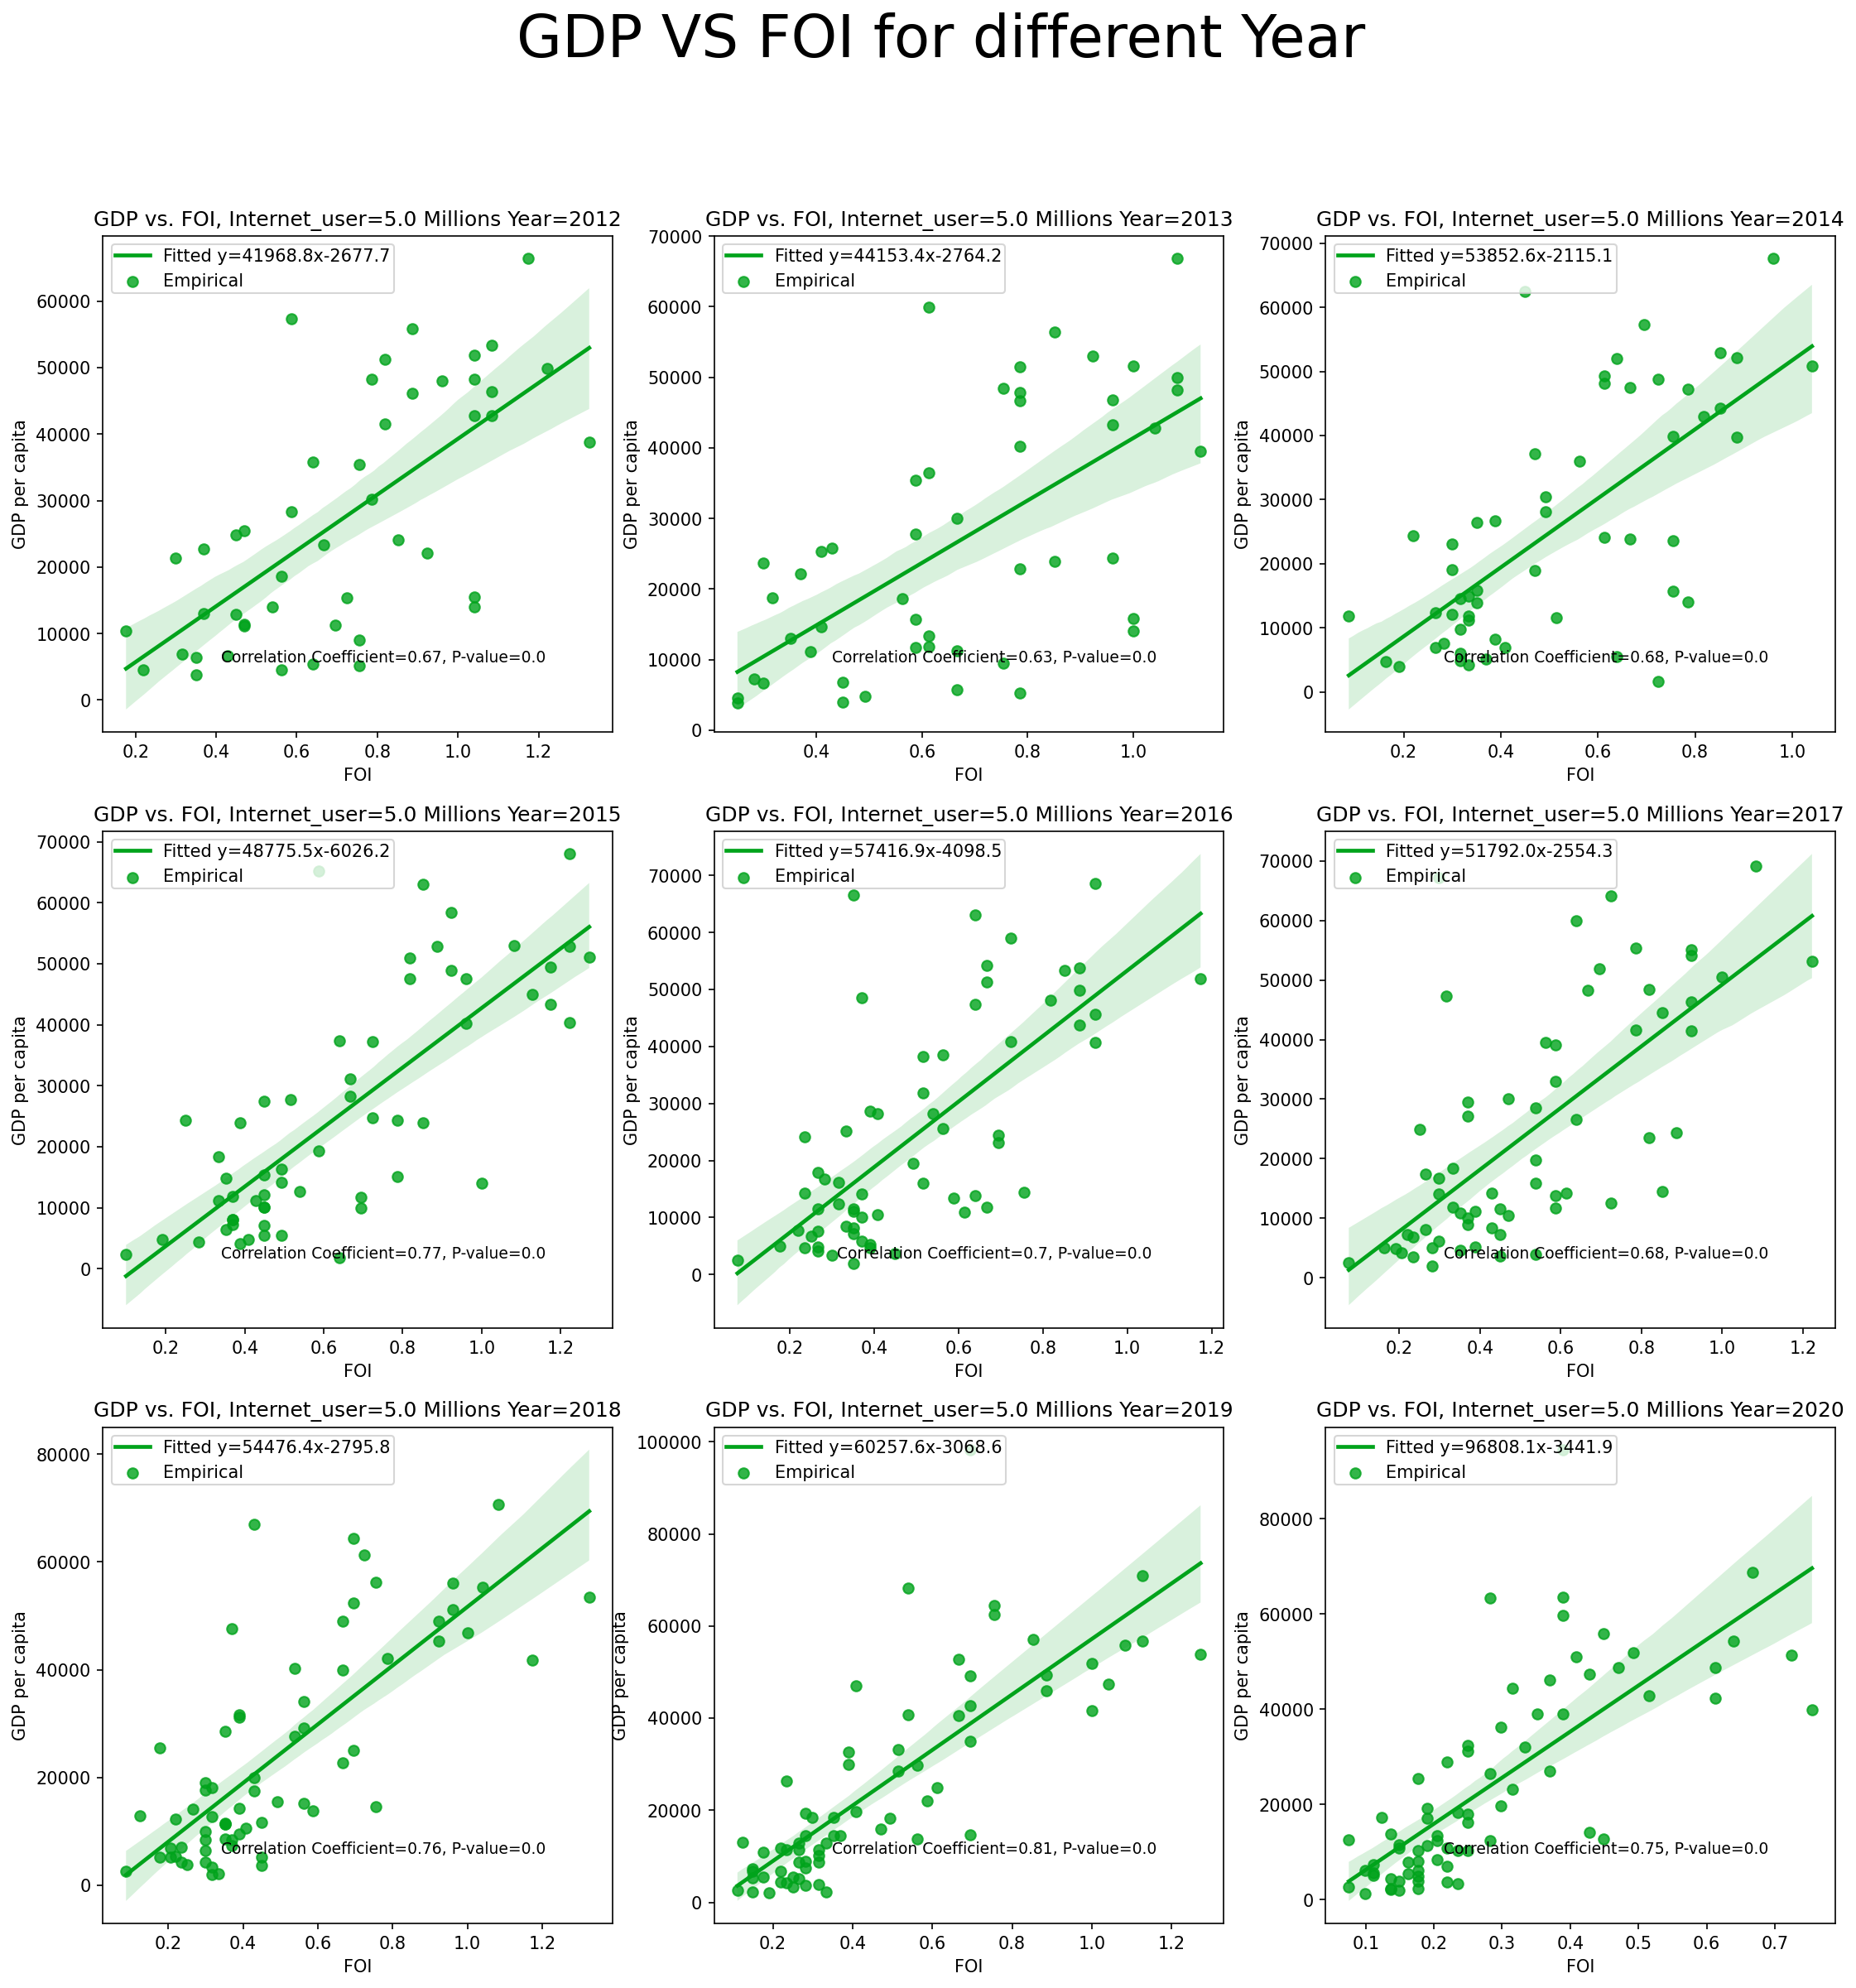

In [231]:
import seaborn as sns
fig , ax= plt.subplots(nrows=3 , ncols=3 , figsize=(18 , 18) , dpi=150)
ax=ax.flat
for i in range(len(ax)):
  value=5e6
  year=i+2012
  plot_scatter(year,value,ax[i],'#00A31B')
fig.suptitle('GDP VS FOI for different Years', fontsize=34)